In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [28]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import json

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from dataset import FreiHAND
from utils import (
    blur_heatmaps,
    IoULoss,
    COLORMAP,
    N_KEYPOINTS,
    N_IMG_CHANNELS,
    get_norm_params,
    show_data,
)
from model import ShallowUNet
from trainer import Trainer

### Train Parameters

In [3]:
config = {
    "data_dir": "data/FreiHAND_pub_v2",
    "epochs": 1000,
    "batch_size": 2,
    "batches_per_epoch": 1,
    "batches_per_epoch_val": 1,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

## Data

In [4]:
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

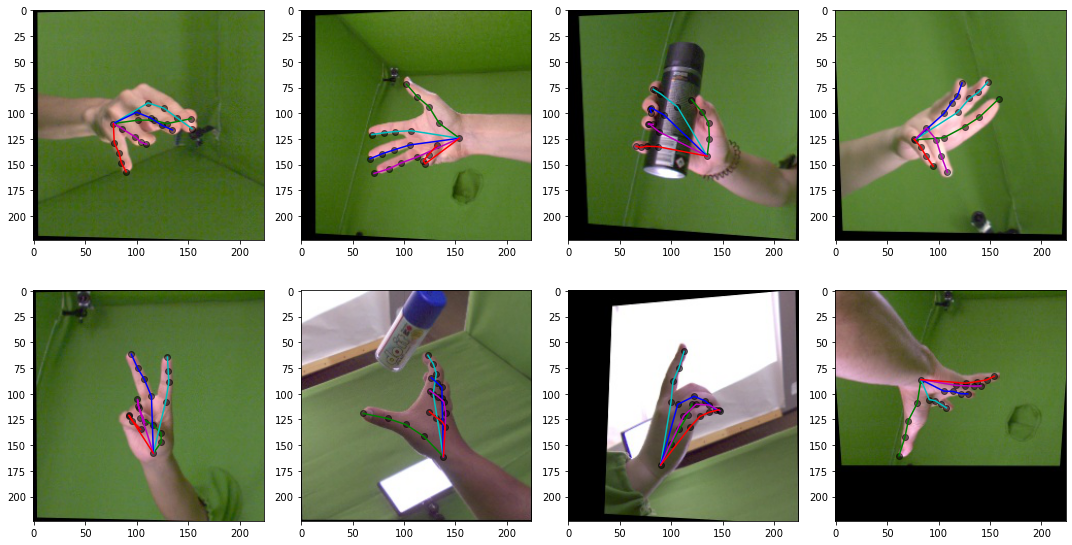

In [31]:
# visualize random batch of data train samples + labels
show_data(train_dataset, n_samples=8)

## Model

In [8]:
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

## Training

In [9]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.9932667613, Val Loss=0.9930975437
Epoch: 2/1000, Train Loss=0.9931186438, Val Loss=0.9931000471
Epoch: 3/1000, Train Loss=0.9932265282, Val Loss=0.9931026399
Epoch: 4/1000, Train Loss=0.9930784702, Val Loss=0.9931047559
Epoch: 5/1000, Train Loss=0.9930846095, Val Loss=0.9931073785
Epoch: 6/1000, Train Loss=0.9930450916, Val Loss=0.9931104183
Epoch: 7/1000, Train Loss=0.9930478334, Val Loss=0.993114382
Epoch: 8/1000, Train Loss=0.993026495, Val Loss=0.9931185842
Epoch: 9/1000, Train Loss=0.993135035, Val Loss=0.9931218624
Epoch: 10/1000, Train Loss=0.9929990768, Val Loss=0.9931262732
Epoch: 11/1000, Train Loss=0.9929873347, Val Loss=0.9931306839
Epoch: 12/1000, Train Loss=0.9930233359, Val Loss=0.9931338727
Epoch: 13/1000, Train Loss=0.9929865003, Val Loss=0.993134886
Epoch: 14/1000, Train Loss=0.9929205179, Val Loss=0.9931380749
Epoch: 15/1000, Train Loss=0.9929623604, Val Loss=0.9931399524
Epoch: 16/1000, Train Loss=0.9928562641, Val Loss=0.9931408167
Epoch

KeyboardInterrupt: 

In [ ]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()